In [1]:
import pandas as pd
import csv
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from keras.models import load_model
import os
import pandas as pd
from keras.preprocessing import image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
import matplotlib.gridspec as gridspec

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
from sklearn import preprocessing
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
### User image identification and extraction 
!pip install keras_maskrcnn
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras
import keras_maskrcnn
import keras_retinanet 

# import keras_retinanet
from keras_maskrcnn import models
from keras_maskrcnn.utils.visualization import draw_mask
from keras_retinanet.utils.visualization import draw_box, draw_caption, draw_annotations
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import shutil 
import numpy as np
import time
import json



# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
### User image identification and extraction 

# adjust this to point to your downloaded/trained model
model_path = os.path.join('/home/ec2-user/SageMaker/inspo-book/', 'resnet50_modanet.h5')

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')
#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {1: 'bag', 2: 'belt', 3: 'boots', 4: 'footwear', 5: 'outer', 6: 'dress', 7: 'sunglasses', 8: 'pants', 9: 'top', 10: 'shorts', 11: 'skirt', 12: 'headwear', 13: 'scarf/tie'}








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
box_ind is deprecated, use box_indices instead









In [27]:
def cloth_identifier(input_imagefile):
    # load image
    image = read_image_bgr(input_imagefile)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    outputs = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    boxes  = outputs[-4][0]
    scores = outputs[-3][0]
    labels = outputs[-2][0]
    masks  = outputs[-1][0]

    # correct for image scale
    boxes /= scale

    masks_dic={}
    boxes_dic={}
    labels_dic={}
    counter=0

    # visualize detections
    for box, score, label, mask in zip(boxes, scores, labels, masks):
        if score < 0.5:
            break
    

        color = label_color(label)
    
        b = box.astype(int)
        draw_box(draw, b, color=color)
    
        mask = mask[:, :, label]
        draw_mask(draw, b, mask, color=label_color(label))
    
        masks_dic[str(counter)]=mask
        boxes_dic[str(counter)]=box
        labels_dic[str(counter)]=label
        counter+=1

    return draw, masks_dic, boxes_dic, labels_dic



In [40]:
### This is the function to extract clothing items separately from an image, given 
### the image and masks and boxes (as dictionaries) extracted using the function 'cloth_identifier'
### and returns a separate image file for each identfied clothing, based on the masks

def cloth_extract(input_imagefile, masks_dic, boxes_dic, labels_dic):
    
    # load image
    image = read_image_bgr(input_imagefile)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # visualize detections

    items_dic={}
    counter=0

    for box, mask2, label2 in zip(boxes_dic.values(), masks_dic.values(), labels_dic.values()):
        b = box.astype(int)

        # resize to fit the box
        mask2 = mask2.astype(np.float32)
        mask2 = cv2.resize(mask2, (b[2] - b[0], b[3] - b[1]))

        # binarize the mask1
        mask2 = (mask2 > 0.5).astype(np.uint8)

        # draw the mask2 in the image
        mask2_image = np.zeros((draw.shape[0], draw.shape[1]), np.uint8)
        mask2_image[b[1]:b[3], b[0]:b[2]] = mask2
        mask2 = mask2_image

        mask2 = (np.stack([mask2] * 3, axis = 2))*draw
        
        items_dic[str(counter)] = mask2
        counter+=1
    
        newfileneame=input_imagefile.split("/")[4].split('.')[0]
        plt.ioff()
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(mask2)
        #plt.savefig('/home/ec2-user/SageMaker/'+str(newfileneame)+'-masked-'+str(label2)+'.jpg',bbox_inches='tight', pad_inches=0)
        #plt.show()
        plt.close('all')
        
    
  
  
  
    return mask2, label2



In [52]:
### User image identification and extraction 

draw, masks_dic, boxes_dic, labels_dic = cloth_identifier('/home/ec2-user/SageMaker/inspo-book/black_1.jpg')

processing time:  0.5573856830596924


In [53]:
mask1, label = cloth_extract('/home/ec2-user/SageMaker/inspo-book/black_1.jpg', masks_dic, boxes_dic, labels_dic)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(mask1)
plt.show()
#label_name=labels_to_names[label+1]
print(label)


UnboundLocalError: local variable 'mask2' referenced before assignment

In [233]:
## Converting the extracted np array to an image 

from PIL import Image
testimg = Image.fromarray(mask, 'RGB')
testimg = testimg.resize((224,224))
testimg.show()

In [243]:
# loading model file for AlexNEt
an_model = load_model("/home/ec2-user/SageMaker/inspo-book/AlexNetFeEx/an-model.h5")


MemoryError: 

In [ ]:
#Loading the weights for AlexNet
import tensorflow as tf

an_model.layers[0].set_weights([tf.train.load_variable('/home/ec2-user/SageMaker/inspo-book/AlexNetFeEx/model.ckpt-5000', 
                                            'conv2d/kernel'), 
                    tf.train.load_variable('/home/ec2-user/SageMaker/inspo-book/AlexNetFeEx/model.ckpt-5000', 
                                           'conv2d/bias')])
an_model.layers[3].set_weights([tf.train.load_variable('/home/ec2-user/SageMaker/inspo-book/AlexNetFeEx/model.ckpt-5000', 
                                            'conv2d_1/kernel'), 
                    tf.train.load_variable('/home/ec2-user/SageMaker/inspo-book/AlexNetFeEx/model.ckpt-5000', 
                                           'conv2d_1/bias')])
an_model.layers[6].set_weights([tf.train.load_variable('/home/ec2-user/SageMaker/inspo-book/AlexNetFeEx/model.ckpt-5000', 
                                            'conv2d_2/kernel'), 
                    tf.train.load_variable('/home/ec2-user/SageMaker/inspo-book/AlexNetFeEx/model.ckpt-5000', 
                                           'conv2d_2/bias')])
an_model.layers[8].set_weights([tf.train.load_variable('/home/ec2-user/SageMaker/inspo-book/AlexNetFeEx/model.ckpt-5000', 
                                            'conv2d_3/kernel'), 
                    tf.train.load_variable('/home/ec2-user/SageMaker/inspo-book/AlexNetFeEx/model.ckpt-5000', 
                                           'conv2d_3/bias')])
an_model.layers[10].set_weights([tf.train.load_variable('/home/ec2-user/SageMaker/inspo-book/AlexNetFeEx/model.ckpt-5000', 
                                            'conv2d_4/kernel'), 
                    tf.train.load_variable('/home/ec2-user/SageMaker/inspo-book/AlexNetFeEx/model.ckpt-5000', 
                                           'conv2d_4/bias')])
an_model.layers[13].set_weights([tf.train.load_variable('/home/ec2-user/SageMaker/inspo-book/AlexNetFeEx/model.ckpt-5000', 
                                            'dense/kernel'), 
                    tf.train.load_variable('/home/ec2-user/SageMaker/inspo-book/AlexNetFeEx/model.ckpt-5000', 
                                           'dense/bias')])
an_model.layers[16].set_weights([tf.train.load_variable('/home/ec2-user/SageMaker/inspo-book/AlexNetFeEx/model.ckpt-5000', 
                                            'dense_1/kernel'), 
                    tf.train.load_variable('/home/ec2-user/SageMaker/inspo-book/AlexNetFeEx/model.ckpt-5000', 
                                           'dense_1/bias')])


In [ ]:
# Extracting features from user test using AlexNet 
INV3_feature_dic = {}
INV3_feature_list=[]


img_data = image.img_to_array(testimg)
img_data = np.expand_dims(img_data, axis=0)
#img_data = preprocess_input(img_data)
INV3_feature = an_model.predict(img_data)
feature_np = np.array(INV3_feature)
testfeature = feature_np.flatten()

In [ ]:
len(testfeature)

In [ ]:
#Importing reddit features 

features =pd.read_csv('an_features.csv', index_col='names')
features.head()

In [ ]:
testfeature = testfeature.reshape(1, -1)
testfeature = np.append(testfeature, label)
testfeature = np.append(testfeature, label)
testfeature = pd.Series(testfeature, index = features.columns, name = 'test')
print(testfeature.shape)

In [ ]:
features_withtest = features.append(testfeature)
features_withtest.tail()

In [ ]:
### replace test label name with name instead of number 

features_withtest['label names'][features_withtest['label names'] == features_withtest['label names']['test'] ] = labels_to_names[features_withtest['label names']['test']+1]

In [ ]:
features_withtest.tail()

In [235]:
### Scaling

scaler = preprocessing.StandardScaler()
#features_withtest.loc[:,'0':'4095'] = scaler.fit_transform(features_withtest.loc[:,'0':'4095'])

In [236]:
## new df with test and train images of same class

sample_df = features_withtest.loc[features_withtest['labels'] == label]
print(sample_df.shape)
sample_df.head()

(19, 4098)


,0,1,2,3,4,5,6,7,8,9,...,4088,4089,4090,4091,4092,4093,4094,4095,labels,label names
names,,,,,,,,,,,,,,,,,,,,,
14+4-masked-5.jpg,1.914013,-1.050028,0.119059,-1.606866,-0.387809,-0.089958,-1.118083,-1.824183,0.082268,0.791155,...,-0.394345,-0.929268,-0.244243,-0.427133,-0.916139,-0.239145,-0.304287,1.799088,5.0,dress
72+5-masked-5.jpg,1.578289,-0.717169,0.022775,-1.186836,0.066738,-0.335805,-0.791579,-1.205605,0.135716,0.587432,...,-0.463644,-0.647620,-0.213059,-0.088815,-0.563576,-0.105547,-0.246549,0.903794,5.0,dress
64+26-masked-5.jpg,1.367742,-0.645089,-0.074323,-1.073283,-0.119812,-0.397379,-0.865762,-1.350523,0.208263,0.720257,...,-0.344824,-0.304278,-0.138677,-0.162578,-0.579637,-0.113238,-0.384019,0.727003,5.0,dress
51+10-masked-5.jpg,1.474560,-0.785439,-0.153639,-1.135319,-0.194866,-0.203202,-0.873073,-1.417323,0.129592,0.685316,...,-0.361705,-0.617589,-0.240512,-0.199476,-0.598232,0.144644,-0.281917,0.876122,5.0,dress
57+6-masked-5.jpg,1.949119,-0.880268,0.312055,-1.762850,-0.227337,-0.320464,-1.233484,-1.565711,0.292741,0.806325,...,-0.509697,-0.748724,-0.357047,-0.451297,-1.017503,-0.216066,-0.527539,1.091212,5.0,dress


In [237]:
### Cosine similarities between test and all train images of sample
from sklearn.metrics.pairwise import cosine_similarity
cos_val = cosine_similarity(sample_df.iloc[:, :2048], sample_df.iloc[-1:, :2048])

cos_val=cos_val.reshape(-1,)

In [238]:
sample_df['cosine'] = pd.Series(cos_val, index=sample_df.index)

In [239]:
sample_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,4089,4090,4091,4092,4093,4094,4095,labels,label names,cosine
names,,,,,,,,,,,,,,,,,,,,,
58+30-masked-5.jpg,1.689936,-0.848649,0.122548,-1.234501,-0.236702,-0.418515,-0.882257,-1.315709,0.283516,0.723855,...,-0.401281,-0.159745,-0.198126,-0.730292,-0.122696,-0.338968,0.792151,5.0,dress,0.948787
46+3-masked-5.jpg,1.221966,-0.459583,0.127103,-0.889681,-0.029125,-0.220712,-0.700711,-1.130375,0.258856,0.733259,...,-0.498348,0.006779,-0.312309,-0.587453,-0.008753,-0.238605,0.554515,5.0,dress,0.946517
17+19-masked-5.jpg,1.612360,-0.768174,-0.188646,-0.694170,-0.107059,-0.219715,-0.373449,-1.187846,0.072382,0.783380,...,-0.785179,-0.060990,-0.295516,-0.075564,-0.030401,-0.151172,0.500992,5.0,dress,0.927863
68+11-masked-5.jpg,1.873264,-1.132436,0.194249,-1.292232,-0.498473,-0.393903,-1.270161,-1.549097,0.450509,0.972832,...,-0.562042,-0.294179,-0.249392,-0.881800,-0.072015,-0.750417,1.157013,5.0,dress,0.952781
test,0.951342,-0.667617,0.279541,-0.639856,-0.301654,-0.322811,-0.624953,-0.901681,-0.125718,0.639228,...,-0.500526,-0.093584,-0.198438,-0.166056,-0.212633,-0.337969,0.837043,5.0,dress,1.000000


In [240]:
sample_df_sort=sample_df.sort_values(by=['cosine'], ascending = False)
sample_df_sort.head()

,0,1,2,3,4,5,6,7,8,9,...,4089,4090,4091,4092,4093,4094,4095,labels,label names,cosine
names,,,,,,,,,,,,,,,,,,,,,
test,0.951342,-0.667617,0.279541,-0.639856,-0.301654,-0.322811,-0.624953,-0.901681,-0.125718,0.639228,...,-0.500526,-0.093584,-0.198438,-0.166056,-0.212633,-0.337969,0.837043,5.0,dress,1.000000
57+6-masked-5.jpg,1.949119,-0.880268,0.312055,-1.762850,-0.227337,-0.320464,-1.233484,-1.565711,0.292741,0.806325,...,-0.748724,-0.357047,-0.451297,-1.017503,-0.216066,-0.527539,1.091212,5.0,dress,0.952881
68+11-masked-5.jpg,1.873264,-1.132436,0.194249,-1.292232,-0.498473,-0.393903,-1.270161,-1.549097,0.450509,0.972832,...,-0.562042,-0.294179,-0.249392,-0.881800,-0.072015,-0.750417,1.157013,5.0,dress,0.952781
14+4-masked-5.jpg,1.914013,-1.050028,0.119059,-1.606866,-0.387809,-0.089958,-1.118083,-1.824183,0.082268,0.791155,...,-0.929268,-0.244243,-0.427133,-0.916139,-0.239145,-0.304287,1.799088,5.0,dress,0.951731
51+10-masked-5.jpg,1.474560,-0.785439,-0.153639,-1.135319,-0.194866,-0.203202,-0.873073,-1.417323,0.129592,0.685316,...,-0.617589,-0.240512,-0.199476,-0.598232,0.144644,-0.281917,0.876122,5.0,dress,0.951507


In [241]:
#number of similar matches 
n = 8
number = n

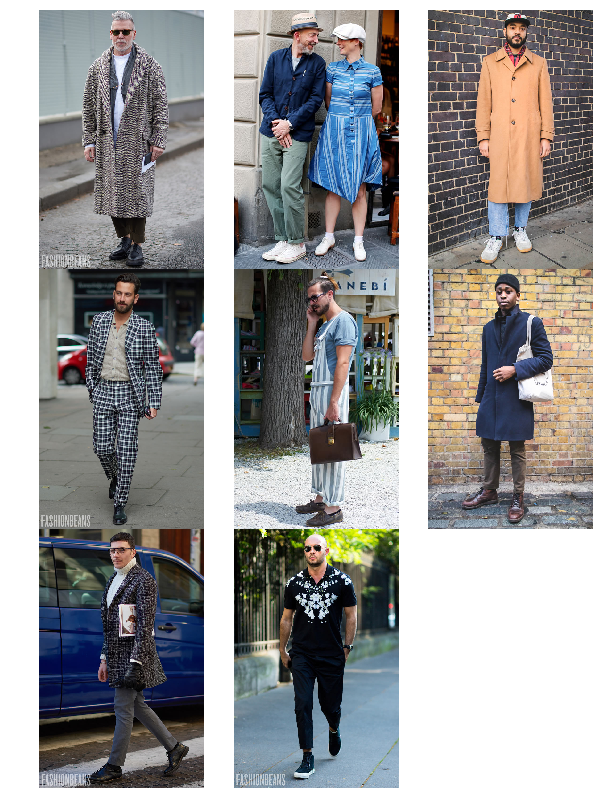

In [242]:
fig5 = plt.figure(constrained_layout=True,figsize=(12,12))

spec5 = gridspec.GridSpec(ncols=3, nrows=1+number//3)
spec5.update(wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845) 
counter=1
for row in range(1+number//3):
    for col in range(3):
        if counter < 1+number:
            ax = fig5.add_subplot(spec5[row, col])
            ax.imshow(mpimg.imread('/home/ec2-user/SageMaker/inspo-book/fashionbeans/processedimages/'+str(sample_df_sort.index[counter]).split('-')[0]+'.jpg'))
            ax.axis('off')
            
            counter+=1

plt.show()